# SanityChecker: 

### Patch Clamp Electrophysiology Notebook that implements low level methods from PatchAnalyzer to do patch analysis without a GUI.



In [1]:
# ------------------------------------------------------------------
# Make the *outer* repo folder importable
# ------------------------------------------------------------------
import sys
from pathlib import Path
import pandas as pd

nb_path   = Path.cwd()                 # e.g. …/ProjectRoot/PatchAnalyzer/AnalysisTesting
repo_root = nb_path.parents[1]         # go up two levels → …/ProjectRoot/

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# sanity check (optional)
# print("repo root on sys.path:", repo_root)


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as W
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


# ------------------------------------------------------------------
# PatchAnalyzer helpers
# ------------------------------------------------------------------
from PatchAnalyzer.models.data_loader import load_metadata
from PatchAnalyzer.models.ephys_loader import (
    load_voltage_traces_for_indices,
    load_current_traces,          # nested CC helper
)
from PatchAnalyzer.utils.passives import (
    compute_passive_params,       # VC
    compute_cc_passive_params,    # CC
)
from PatchAnalyzer.utils.spike_params import (
    Sweep,
    calc_firing_curve,
    calc_spike_metrics,
)

plt.rcParams["figure.dpi"] = 110


2025-07-14 15:35:03,752 [INFO] Logging to C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\PatchAnalyzer\logs\run-20250714-153503.log


In [3]:
# Select multiple experiment dirs the same way the GUI’s WelcomePage does
exp_dirs = [
    # Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-12_09"),   # TODO – add as many as you like
    # Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-13_07"),
    # Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-13_30"),
    Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-15_58"),
    
    # Path("/path/to/another/experiment"),
]
exp_dirs


[WindowsPath('C:/Users/sa-forest/Documents/GitHub/PatchAnalyzer/Data/Test/2025_06_25-15_58')]

In [4]:
# ---------------------------------------------------------------------------
# Build `cells`  →  key = (exp_dir, (x,y,z))
#                   val = {"vc": [...], "cc": {cell_id: {current: trace}} }
# ---------------------------------------------------------------------------
cells = {}

meta_frames = []
for exp in exp_dirs:
    try:
        meta_frames.append(load_metadata([exp]))
    except ValueError:
        print(f"⚠  No CellMetadata in {exp}")

if not meta_frames:
    raise RuntimeError("No cell metadata loaded – check folder paths.")

meta_df = pd.concat(meta_frames, ignore_index=True)

idx_col = "indices" if "indices" in meta_df.columns else "index"
if idx_col not in meta_df.columns:
    raise RuntimeError("Neither “indices” nor “index” column found in metadata")

for coord, sub in meta_df.groupby(["stage_x", "stage_y", "stage_z"]):
    exp_dir       = Path(sub["src_dir"].iloc[0])
    sweep_indices = sub[idx_col].tolist()        # list[int]  → cell numbers

    # --- Voltage-clamp
    vc_traces = [
        (t, cmd, rsp)
        for idx in sweep_indices
        for (t, cmd, rsp) in load_voltage_traces_for_indices(exp_dir, [idx]).values()
    ]

    # --- Current-clamp   nested {cell_id ▶ current ▶ trace}
    cc_nested = load_current_traces(exp_dir, sweep_indices)

    cells[(exp_dir, coord)] = dict(vc=vc_traces, cc=cc_nested)

print(f"Found {len(cells)} unique physical cells")


2025-07-14 15:35:04,149 [INFO] Loaded 6 rows from C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-15_58\CellMetadata\cell_metadata.csv
Found 2 unique physical cells


In [5]:
for (exp, coord), d in cells.items():
    n_vc = len(d['vc'])
    n_cc = sum(len(cur_dict) for cur_dict in d['cc'].values())
    print(f"{exp.name} {coord}: {n_vc} VC traces, {n_cc} CC traces")
    for cid, cur_dict in d['cc'].items():
        print(f"    cell {cid}: {len(cur_dict)} CC sweeps")



2025_06_25-15_58 (np.float64(2191.924664667212), np.float64(48866.046024274525), np.float64(20327.8)): 5 VC traces, 151 CC traces
    cell 2: 23 CC sweeps
    cell 3: 25 CC sweeps
    cell 4: 33 CC sweeps
    cell 5: 35 CC sweeps
    cell 6: 35 CC sweeps
2025_06_25-15_58 (np.float64(2906.2965543591563), np.float64(45936.06428926166), np.float64(20372.9)): 1 VC traces, 5 CC traces
    cell 1: 5 CC sweeps


In [6]:
# ---------- choose the physical cell & recorder cell-number -------------
exp_dir   = exp_dirs[0]          # one experiment          (dropdown if you like)
cell_id   = 4                    # the *CurrentProtocol_* <cell_id>  you want
test_amp  = -20                  # pA – amplitude of the test pulse


In [7]:
# ────────── VC passive extraction for this physical cell ──────────
from PatchAnalyzer.utils.passives import compute_passive_params
import numpy as np

# locate the (exp_dir, coord) key that matches this experiment
coord_key = next(k for k in cells if k[0] == exp_dir)
data      = cells[coord_key]

vc_traces = data["vc"]                    # list of (t, cmd, rsp)
vc_outs   = [compute_passive_params(*tr) for tr in vc_traces]
vc_valid  = [o for o in vc_outs if all(v is not None for v in o)]

if vc_valid:
    Ra_mohm, Rm_mohm, Cm_pf = map(np.mean, zip(*vc_valid))
    print(f"Voltage‑clamp (mean of {len(vc_valid)} fits):")
    print(f"  Ra = {Ra_mohm:.1f} MΩ   Rm = {Rm_mohm:.1f} MΩ   Cm = {Cm_pf:.1f} pF")
else:
    Ra_mohm = Rm_mohm = Cm_pf = np.nan
    print("No successful VC passive fits.")

# keep these three variables for later comparison if you wish


Voltage‑clamp (mean of 5 fits):
  Ra = 36.3 MΩ   Rm = 48.1 MΩ   Cm = 139.3 pF


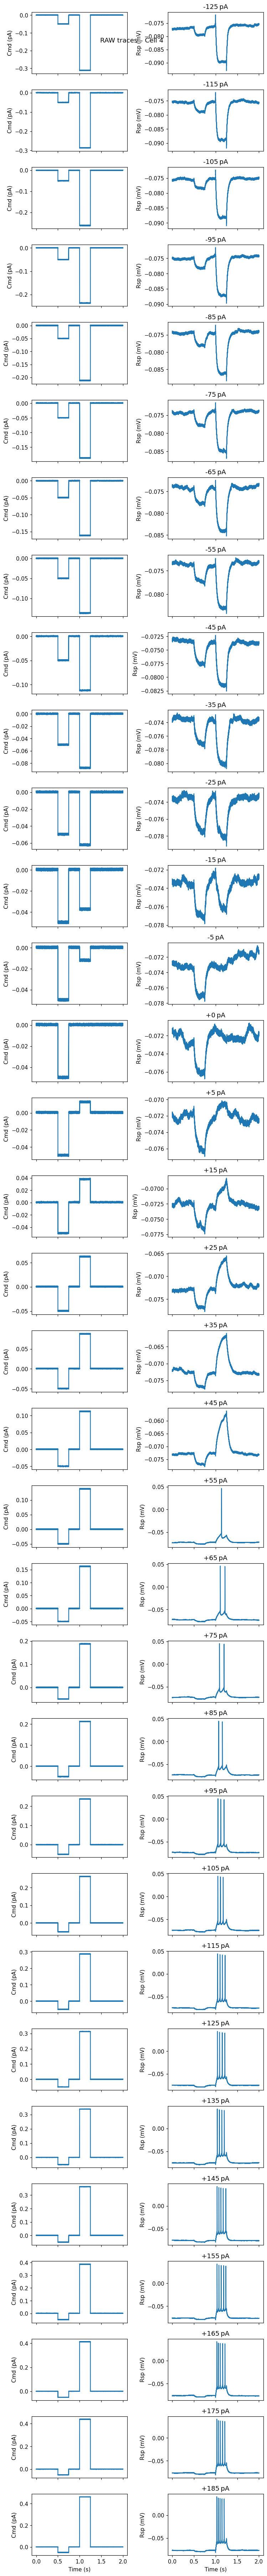

In [8]:
# ----------- gather sweeps for *one* (exp_dir, coord) --------------------
key     = coord_key                    # re‑use variable from the VC cell
cc_dict = cells[key]["cc"]             # {cell_id: {current: trace}}
sweeps  = cc_dict.get(cell_id, {})     # all sweeps for this cell_id
if not sweeps:
    raise RuntimeError(f"No CC sweeps found for cell {cell_id}")

# ---------- plot *entire* command/response for every sweep ---------------
fig, axs = plt.subplots(len(sweeps), 2,
                        figsize=(7, 2*len(sweeps)), sharex='col')
for (I, (t, cmd, rsp)), ax in zip(sorted(sweeps.items()), axs):
    ax[0].plot(t, cmd);  ax[0].set_ylabel("Cmd (pA)")
    ax[1].plot(t, rsp);  ax[1].set_ylabel("Rsp (mV)")
    ax[1].set_title(f"{I:+.0f} pA")
for a in axs[-1]:
    a.set_xlabel("Time (s)")
plt.suptitle(f"RAW traces – Cell {cell_id}"); plt.tight_layout(); plt.show()


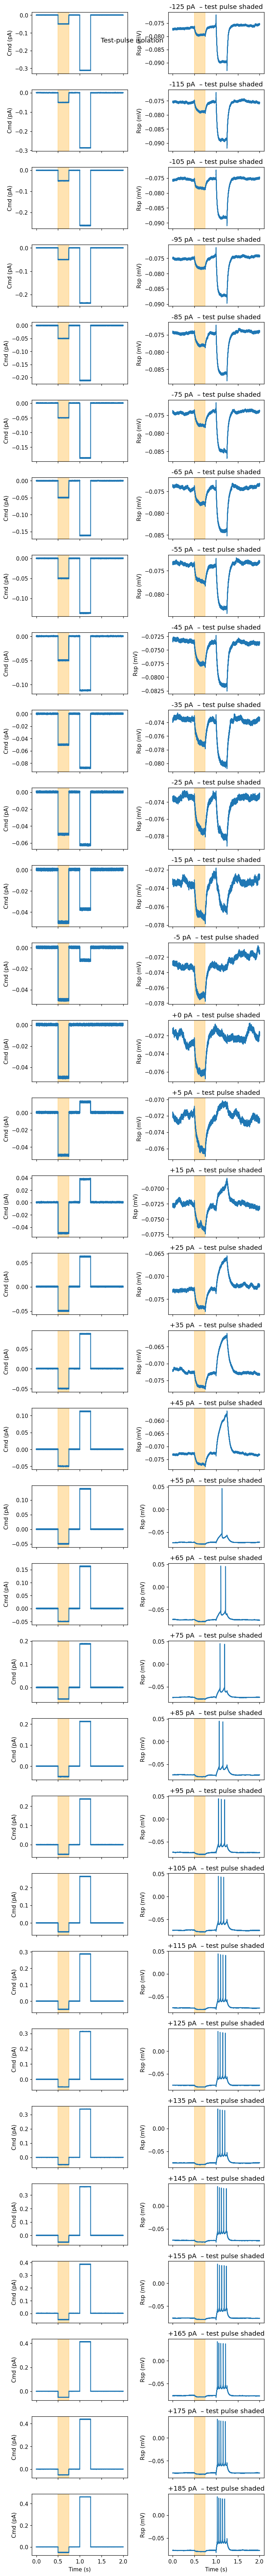

In [9]:
# helper --------------------------------------------------------------
def find_test_pulse(cmd, edge_frac=0.10, min_sep_pts=5):
    """
    Locate the first current pulse via dCmd/dt:

        • negative slope   →  start
        • positive slope   →  end   (if absent, pulse assumed till trace end)

    Parameters
    ----------
    cmd : 1‑D array (pA)
    edge_frac : float
        Fraction of the *maximum absolute* derivative used as threshold.
        0.10 ⇒ edges with |dI/dt| ≥ 10 % of the largest slope are considered.
    min_sep_pts : int
        Minimum distance (samples) between the start and end edges to avoid
        catching noise.
    Returns
    -------
    (s, e) : tuple[int, int]   indices in *cmd*
             or (None, None) if no downward edge found.
    """
    cmd = np.asarray(cmd)
    d   = np.diff(cmd, prepend=cmd[0])

    thr = edge_frac * np.max(np.abs(d))
    starts = np.where(d < -thr)[0]
    if starts.size == 0:
        return None, None       # no clear downward edge

    s = int(starts[0])

    ends = np.where((np.arange(len(d)) > s + min_sep_pts) & (d > thr))[0]
    e = int(ends[0]) if ends.size else len(cmd) - 1   # fall back to last point
    return s, e



# truncate & visualise -------------------------------------------------
trunc_sweeps = {}      # {I: (t, cmd, rsp, s, e)}
for I, (t, cmd, rsp) in sweeps.items():
    s, e = find_test_pulse(cmd)
    if s is not None and e is not None:
        trunc_sweeps[I] = (t, cmd, rsp, s, e)
    else:
        print(f"⚠  no test pulse detected in sweep {I:+.0f} pA – skipped")

if not trunc_sweeps:
    raise RuntimeError("No sweeps contained a detectable test pulse.")

fig, axs = plt.subplots(len(trunc_sweeps), 2,
                        figsize=(7, 2*len(trunc_sweeps)), sharex='col')
for (I, (t, cmd, rsp, s, e)), ax in zip(sorted(trunc_sweeps.items()), axs):
    ax[0].plot(t, cmd); ax[0].axvspan(t[s], t[e], color='orange', alpha=.3)
    ax[0].set_ylabel("Cmd (pA)")
    ax[1].plot(t, rsp); ax[1].axvspan(t[s], t[e], color='orange', alpha=.3)
    ax[1].set_ylabel("Rsp (mV)")
    ax[1].set_title(f"{I:+.0f} pA  – test pulse shaded")
for a in axs[-1]:
    a.set_xlabel("Time (s)")
plt.suptitle("Test‑pulse isolation"); plt.tight_layout(); plt.show()



C:\Users\sa-forest\AppData\Local\Temp\ipykernel_9904\1534080383.py:13: RuntimeWarning: overflow encountered in exp
  return m * np.exp(-tau_inv * t) + b


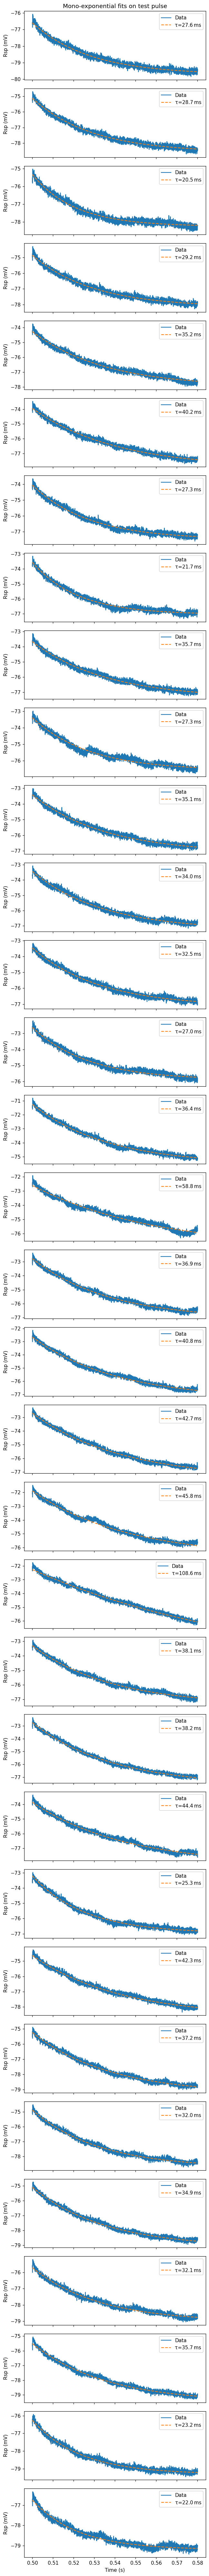

In [ ]:
# --------------------------------------------------------------------------
#  Accurate passive extraction  (volts ➜ millivolts conversion)
# --------------------------------------------------------------------------
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

BASELINE_MS   = 20             # ms
PLATEAU_MS    = 20             # ms
FIT_WINDOW_MS = 80             # ms

def mono_exp(t, m, tau_inv, b):          # t in ms, returns mV
    return m * np.exp(-tau_inv * t) + b

fit_results = []

fig, axs = plt.subplots(len(trunc_sweeps), 1,
                        figsize=(6, 2.2*len(trunc_sweeps)), sharex=True)

for (I, (t, cmd, rsp, s, e)), ax in zip(sorted(trunc_sweeps.items()), axs):
    dt       = t[1] - t[0]
    pre_pts  = int(BASELINE_MS   / 1000 / dt)
    plat_pts = int(PLATEAU_MS    / 1000 / dt)
    fit_pts  = int(FIT_WINDOW_MS / 1000 / dt)

    # ------------------------ volt ➜ mV ---------------------------------
    rsp_mV = rsp * 1000.0

    V_base = np.mean(rsp_mV[max(0, s-pre_pts): s])
    V_plat = np.mean(rsp_mV[max(s, e-plat_pts): e])
    dV_mV  = V_plat - V_base                  # ≈ 1–3 mV

    I_base_pA = np.mean(cmd[max(0, s-pre_pts): s])          # already pA
    I_plat_pA = np.mean(cmd[max(s, e-plat_pts): e])         # already pA
    dI_pA     = I_plat_pA - I_base_pA


    Rin_MΩ = abs(dV_mV / dI_pA)                           # mV / pA  →  MΩ

    Xfit_ms = (t[s:s+fit_pts] - t[s]) * 1000  # ms from onset
    Yfit_mV = rsp_mV[s:s+fit_pts] - V_plat    # decays to 0 mV

    try:
        p, _ = curve_fit(mono_exp, Xfit_ms, Yfit_mV,
                         p0=(Yfit_mV[0], 10, 0), maxfev=20000)
        tau_ms = 1 / p[1]
        Cm_pF  = (tau_ms / Rin_MΩ) * 1000.0    # ms / MΩ → pF


        # --------------------- plot overlay -----------------------------
        ax.plot(t[s:s+fit_pts], Yfit_mV + V_plat, label="Data")
        ax.plot(t[s:s+fit_pts],
                mono_exp(Xfit_ms, *p) + V_plat, "--",
                label=f"τ={tau_ms:.1f} ms")
        ax.set_ylabel("Rsp (mV)"); ax.legend()

        fit_results.append(dict(
            current_pA = I,
            Rin_MOhm   = Rin_MΩ,
            tau_ms     = tau_ms,
            Cm_pF      = Cm_pF,
            Rest_mV    = V_base,     # resting potential
        ))
    except RuntimeError:
        ax.plot(t[s:s+fit_pts], Yfit_mV + V_plat, 'r', label="Fit failed")
        ax.legend()

axs[-1].set_xlabel("Time (s)")
axs[0].set_title("Mono‑exponential fits on test pulse")
plt.tight_layout(); plt.show()



In [11]:
# --------------------------------------------------------------------------
#  Summary table  (one row per sweep + MEAN)
# --------------------------------------------------------------------------
res_df = pd.DataFrame(fit_results)          # columns: current_pA, Rin_MOhm, tau_ms, Cm_pF

if not res_df.empty:
    mean_row = res_df.mean(numeric_only=True).to_dict()
    mean_row["current_pA"] = "MEAN"
    res_df = pd.concat([res_df, pd.DataFrame([mean_row])], ignore_index=True)

display(res_df)

# If you ran the VC‑Rm comparison in Cell E, the printout is already there.



,current_pA,Rin_MOhm,tau_ms,Cm_pF,Rest_mV
0,-125.0,52.706264,27.595479,0.523571,-76.755998
1,-115.0,69.556217,28.716689,0.412856,-75.350372
2,-105.0,55.325689,20.507177,0.370663,-75.719009
3,-95.0,59.682677,29.234362,0.489830,-74.999054
4,-85.0,75.697627,35.169598,0.464606,-74.350097
5,-75.0,75.749158,40.197620,0.530668,-74.118153
6,-65.0,68.660203,27.311702,0.397781,-74.334935
7,-55.0,76.171773,21.734443,0.285335,-73.800401
8,-45.0,78.966725,35.668895,0.451695,-73.649553
9,-35.0,73.069024,27.279058,0.373333,-73.546538


In [ ]:
rows = []
for (exp_dir, coord), data in cells.items():

    # ── Voltage-clamp passives  (average across all VC sweeps)
    ra = rm = cm = None
    if data["vc"]:
        outs = [compute_passive_params(*trace) for trace in data["vc"]]
        valid = [o for o in outs if all(v is not None for v in o)]
        if valid:
            ra, rm, cm = map(lambda x: float(np.mean(x)), zip(*valid))

    # ── Current-clamp passives  (average across every CC sweep of every cell)
    tau = rin = cap = rest = None
    cc_sweeps = [
        trace
        for cell_dict in data["cc"].values()     # per-cell dict
        for trace      in cell_dict.values()     # per-current trace
    ]
    if cc_sweeps:
        outs = [compute_cc_passive_params(*trace) for trace in cc_sweeps]
        valid = [o for o in outs if o["membrane_tau_ms"] is not None]
        if valid:
            tau  = np.mean([o["membrane_tau_ms"]         for o in valid])
            rin  = np.mean([o["input_resistance_MOhm"]   for o in valid])
            cap  = np.mean([o["membrane_capacitance_pF"] for o in valid])
            rest = np.mean([o["resting_potential_mV"]    for o in valid])

    rows.append(dict(
        exp     = exp_dir.name,
        stage_x = coord[0],
        stage_y = coord[1],
        stage_z = coord[2],
        Ra_MOhm = ra,
        Rm_MOhm = rm,
        Cm_pF   = cm,
        Rin_MOhm= rin,
        tau_ms  = tau,
        Cm_CC_pF= cap,
        Rest_mV = rest,
    ))

df = (pd.DataFrame(rows)
        .sort_values(["exp", "stage_x", "stage_y", "stage_z"])
        .reset_index(drop=True))
df.head()


In [12]:
def plot_cell(exp_name, cell_id, clamp="VC"):
    rec = [k for k in cells if k[0].name == exp_name][0]   # 1 exp per dropdown
    data = cells[rec]

    if clamp == "VC":
        for t, cmd, rsp in data["vc"]:
            fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            ax1.plot(t, cmd);  ax1.set_ylabel("Cmd (mV)")
            ax2.plot(t, rsp);  ax2.set_ylabel("Rsp (pA)")
            ax2.set_xlabel("Time (s)")
            fig.suptitle(f"{exp_name} – ({cell_id}) VC")
            plt.show()
    else:
        cc_dict = data["cc"].get(cell_id, {})
        for I, (t, cmd, rsp) in sorted(cc_dict.items()):
            fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            ax1.plot(t, cmd);  ax1.set_ylabel("Cmd (pA)")
            ax2.plot(t, rsp);  ax2.set_ylabel("Rsp (mV)")
            ax2.set_xlabel("Time (s)")
            fig.suptitle(f"{exp_name} – Cell {cell_id}  (CC {I:+.0f} pA)")
            plt.show()


In [13]:
fi_rows = []; spk_rows = []
for (exp_dir, coord), data in cells.items():
    for cell_id, cc_dict in data["cc"].items():
        sweeps = [
            Sweep(time=t, command=cmd, response=rsp,
                  sample_rate=1/(t[1]-t[0]))
            for (t, cmd, rsp) in cc_dict.values()
        ]
        if not sweeps:
            continue

        fi  = calc_firing_curve(sweeps)
        fi["exp"]      = exp_dir.name
        fi["cell_idx"] = cell_id
        fi_rows.append(fi)

        spk = calc_spike_metrics(sweeps)
        spk["exp"]      = exp_dir.name
        spk["cell_idx"] = cell_id
        spk_rows.append(spk)

fi_df  = pd.concat(fi_rows,  ignore_index=True) if fi_rows else pd.DataFrame()
spk_df = pd.concat(spk_rows, ignore_index=True) if spk_rows else pd.DataFrame()


TypeError: Sweep.__init__() got an unexpected keyword argument 'command'